# SQL-Based Analysis
- Explore trends in my Spotify listening data using SQL queries.
- Focus on insights that are either unique to SQL or more efficient using SQL.
- Highlights include longest listening days, genre and artist aggregations, and SQL-derived visualizations.
- Demonstrates the value of structured querying for deeper, relational insights.

In [19]:
import pandas as pd
import os
import json
import sqlite3

# Load all JSON streaming files
data_path = '../data/Spotify Extended Streaming History'
dfs = []

for file in os.listdir(data_path):
    if file.endswith('.json') and file != 'artist_genre_map.json':
        dfs.append(pd.read_json(os.path.join(data_path, file)))

df = pd.concat(dfs, ignore_index=True)
df.rename(columns={'master_metadata_album_artist_name': 'artist'}, inplace=True)

# Load genre map
with open(os.path.join(data_path, 'artist_genre_map.json'), 'r', encoding='utf-8') as f:
    genre_map = json.load(f)

# Assign genres
df['genre'] = df['artist'].map(lambda a: genre_map.get(a, ['Unknown'])[0] if genre_map.get(a) else 'Unknown')

# Drop unknown genres
df = df[df['genre'] != 'Unknown']
print(f"Cleaned dataset has {len(df):,} entries with valid genres.")

# Save to SQLite
conn = sqlite3.connect("spotify_clean.db")
df.to_sql("streaming", conn, if_exists="replace", index=False)
print("Database created: spotify_clean.db with table 'streaming'")

Cleaned dataset has 118,263 entries with valid genres.
Database created: spotify_clean.db with table 'streaming'


## Top Listening Days by Playtime  
Identifies the days where I spent the most time listening to music by summing total minutes played per day.


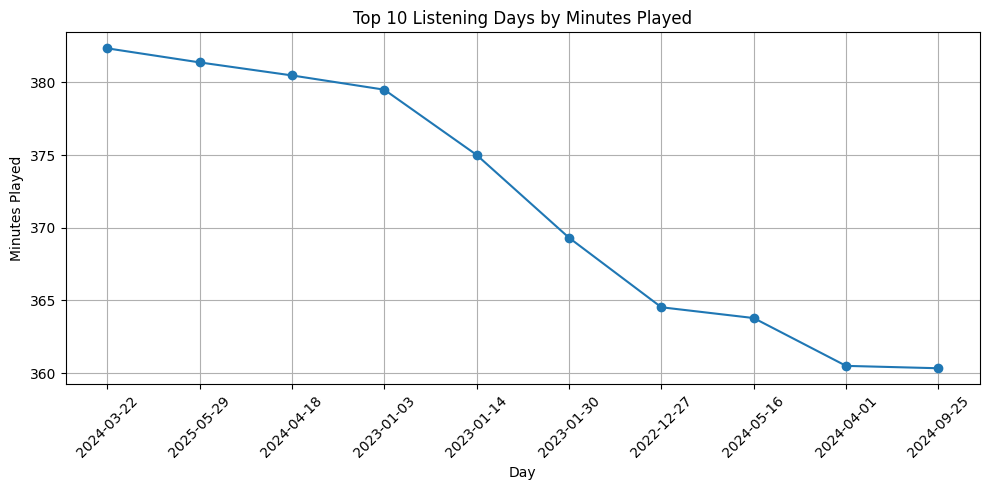

In [20]:
query = """
SELECT DATE(ts) as day, SUM(ms_played) / 60000.0 as minutes_played
FROM streaming
GROUP BY day
ORDER BY minutes_played DESC
LIMIT 10;
"""

top_days = pd.read_sql(query, conn)
top_days

## Visualization

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(top_days['day'], top_days['minutes_played'], marker='o')
plt.title("Top 10 Listening Days by Minutes Played")
plt.xlabel("Day")
plt.ylabel("Minutes Played")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


- The peak listening day was 2024-03-22 with approximately 383 minutes played.
- The lowest in the top 10 was 2024-09-25 at around 361 minutes.
- There is a gradual decline in minutes played over these top days, indicating variability in daily listening engagement.

## Listening Trends by Hour of Day
Analyzes my total listening minutes for each hour of the day to identify peak listening times.

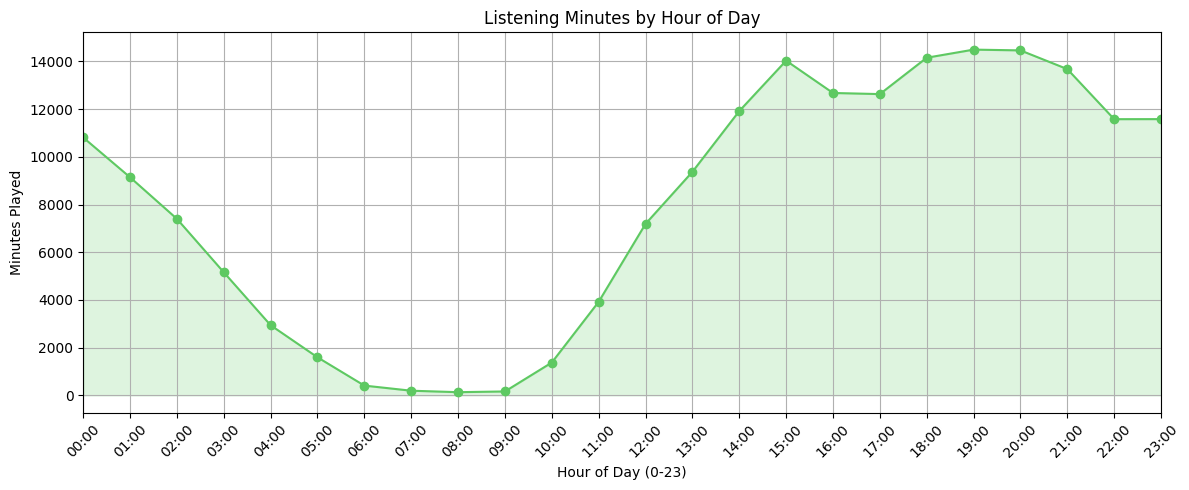

In [21]:
query = """
SELECT CAST(strftime('%H', ts) AS INTEGER) AS hour,
       SUM(ms_played) / 60000.0 AS minutes_played
FROM streaming
GROUP BY hour
ORDER BY hour;
"""

hourly_trends = pd.read_sql(query, conn)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(hourly_trends['hour'], hourly_trends['minutes_played'], marker='o', linestyle='-', color=plt.cm.viridis(0.75))
plt.fill_between(hourly_trends['hour'], hourly_trends['minutes_played'], alpha=0.2, color=plt.cm.viridis(0.75))
plt.xticks(range(0, 24), [f"{h:02d}:00" for h in range(24)], rotation=45)
plt.xlim(0, 23)
plt.title("Listening Minutes by Hour of Day")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Minutes Played")
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


- Listening is highest from mid-afternoon through the evening, peaking around 7-8 PM with over 14,000 total minutes played.
- There’s a sharp drop-off in listening after midnight, hitting near-zero between about 6 AM and 9 AM.
- Listening starts to gradually rise again after 9 AM, with a noticeable increase from 10 AM onwards.
- The lowest engagement hours are the early morning hours (6 to 9 AM), indicating little music activity during typical waking hours.
- Listening engagement is strong during typical active hours (11 AM to 9 PM), showing I'm most engaged with music in the later part of the day.

## Genre Popularity Over Time
Analyzed how my genre preferences changed month-to-month to uncover shifts in my listening habits.

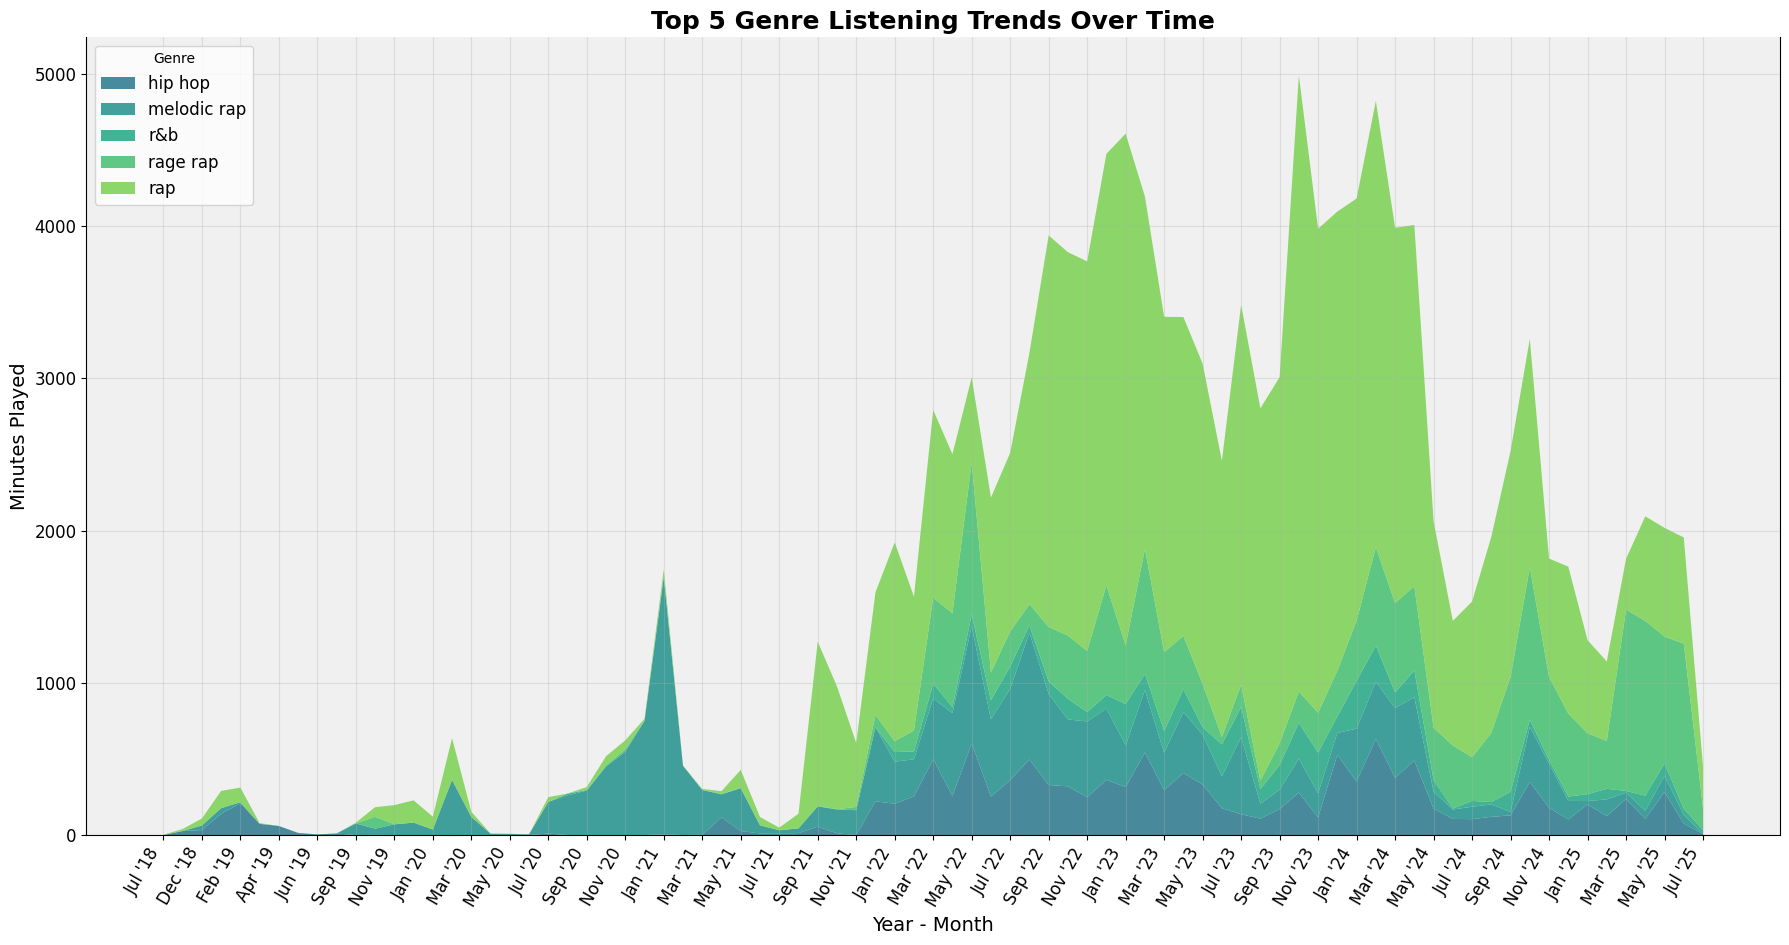

In [22]:
import numpy as np

query = """
SELECT 
    strftime('%Y-%m', DATE(ts)) as month, 
    genre, 
    SUM(ms_played) / 60000.0 as minutes_played
FROM streaming
GROUP BY month, genre
ORDER BY month, minutes_played DESC;
"""


genre_monthly = pd.read_sql(query, conn)

# Sort months to ensure time order
# Filter for top genres and pivot the data
top_genres = ['rap', 'rage rap', 'melodic rap', 'hip hop', 'r&b']  # Example top genres
filtered = genre_monthly[genre_monthly['genre'].isin(top_genres)]
filtered = filtered.pivot(index='month', columns='genre', values='minutes_played').fillna(0)

# Sort months to ensure time order
filtered = filtered.sort_index()

plt.figure(figsize=(18, 10.5))

colors = plt.cm.viridis(np.linspace(0.4, 0.8, len(filtered.columns)))

plt.stackplot(filtered.index, filtered.T, labels=filtered.columns, colors=colors, alpha=0.85)

plt.title("Top 5 Genre Listening Trends Over Time", fontsize=18, weight='bold')
plt.xlabel("Year - Month", fontsize=14)
plt.ylabel("Minutes Played", fontsize=14)

formatted_labels = pd.to_datetime(filtered.index).strftime("%b '%y")
ticks_to_show = range(0, len(formatted_labels), 2)  # every 2 months

plt.yticks(fontsize=12)

# Use reduced ticks with filtered labels here:
plt.xticks(ticks=ticks_to_show, labels=[formatted_labels[i] for i in ticks_to_show], rotation=60, fontsize=12, ha='right')

plt.legend(title='Genre', loc='upper left', fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.gca().set_facecolor('#f0f0f0')
plt.gca().spines['top'].set_visible(False)
plt.subplots_adjust(bottom=0.2)
plt.show()

- I see that rap dominates my listening time consistently from early 2021 through mid-2024, with clear spikes showing it’s my favorite genre by a wide margin.
- Melodic rap and hip hop also keep steady with peaks that often rise alongside rap, which tells me I’m really into those related subgenres too.
- The sharp fluctuations and spikes in listening probably reflect new album releases, seasonal habits, or other events that affect how much I listen over time.

## Top Artists and Genres by Play Count
I want to find which artists and genres I listen to the most overall.

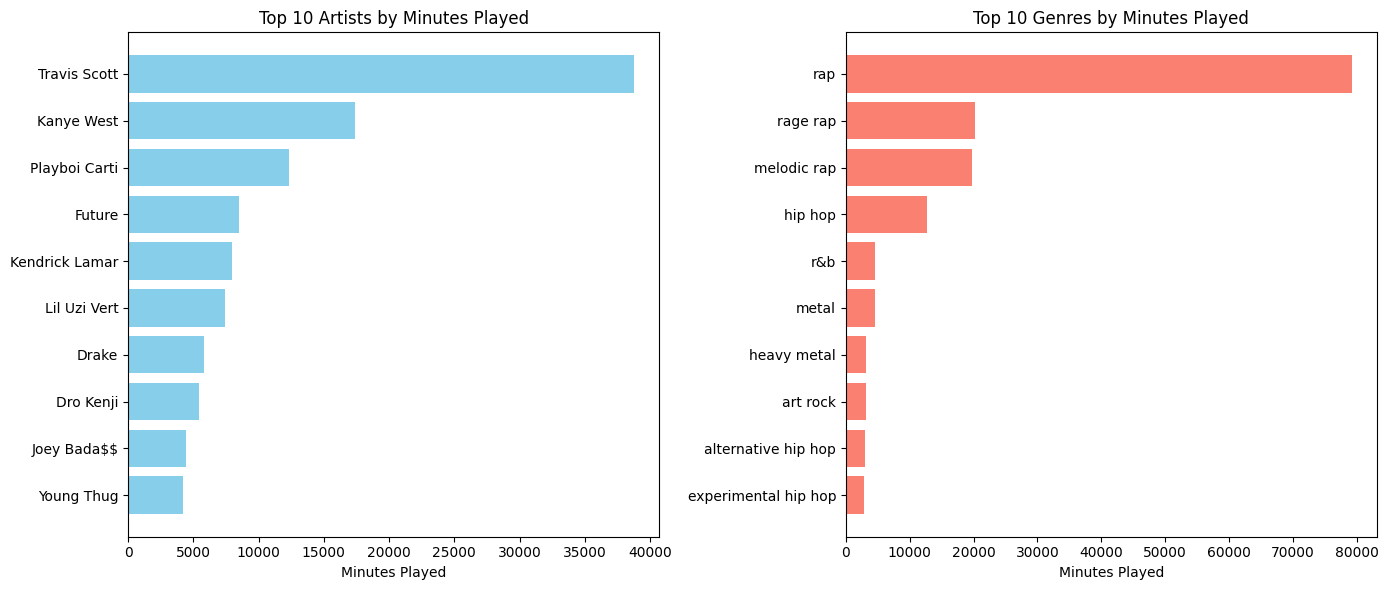

In [23]:
# Top 10 Artists by Total Minutes Played
query_artists = """
SELECT artist, SUM(ms_played) / 60000.0 as minutes_played
FROM streaming
WHERE artist IS NOT NULL
GROUP BY artist
ORDER BY minutes_played DESC
LIMIT 10;
"""
top_artists = pd.read_sql(query_artists, conn)

# Top 10 Genres by Total Minutes Played
query_genres = """
SELECT genre, SUM(ms_played) / 60000.0 as minutes_played
FROM streaming
WHERE genre IS NOT NULL
GROUP BY genre
ORDER BY minutes_played DESC
LIMIT 10;
"""
top_genres = pd.read_sql(query_genres, conn)

top_artists['artist'] = top_artists['artist'].str.replace('$', r'\$', regex=False)
top_genres['genre'] = top_genres['genre'].str.replace('$', r'\$', regex=False)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].barh(top_artists['artist'][::-1], top_artists['minutes_played'][::-1], color='skyblue')
axs[0].set_title('Top 10 Artists by Minutes Played')
axs[0].set_xlabel('Minutes Played')

axs[1].barh(top_genres['genre'][::-1], top_genres['minutes_played'][::-1], color='salmon')
axs[1].set_title('Top 10 Genres by Minutes Played')
axs[1].set_xlabel('Minutes Played')

plt.tight_layout()
plt.show()


- Travis Scott, Kanye, and Playboi Carti dominate my top artists, with Travis way ahead—clearly showing who I keep on repeat the most.
- Rap massively leads my genre listening time, with rage rap, melodic rap, and hip hop trailing behind but still strong—proving how heavily I lean into rap and its subgenres.
- Even though genres like metal, art rock, and R&B show up, they take up a much smaller share of my listening, showing I occasionally branch out but mostly stick to rap.

## Listening Transition Analysis
I used SQL window functions to track how my music listening shifts from one genre to another

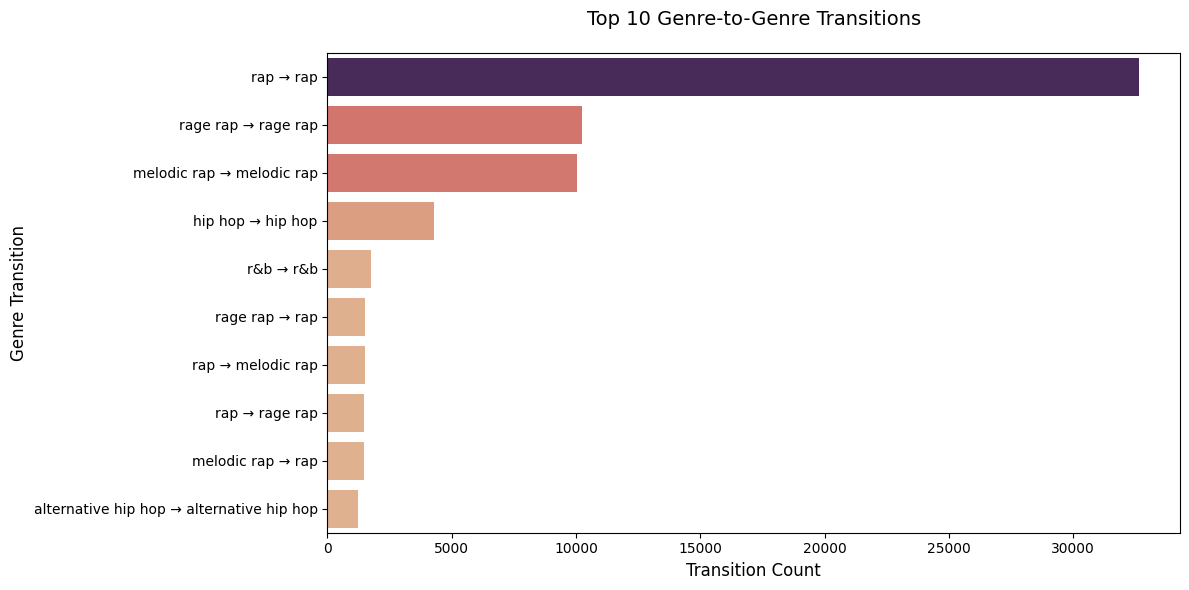

In [24]:
import seaborn as sns

# Run SQL query to get previous and current genre
transition_df = pd.read_sql("""
SELECT
    genre AS current_genre,
    LAG(genre) OVER (ORDER BY ts) AS previous_genre
FROM streaming
WHERE genre IS NOT NULL AND ts IS NOT NULL
""", conn)

# Clean and count transitions
transition_df = transition_df.dropna()
transition_counts = (
    transition_df
    .groupby(['previous_genre', 'current_genre'])
    .size()
    .reset_index(name='count')
)
top_transitions = transition_counts.sort_values('count', ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_transitions,
    x='count',
    y=top_transitions['previous_genre'] + " → " + top_transitions['current_genre'],
    palette='flare',
    hue='count',
    dodge=False,
    legend=False
)
plt.title("Top 10 Genre-to-Genre Transitions", fontsize=14, pad=20)
plt.xlabel("Transition Count", fontsize=12)
plt.ylabel("Genre Transition", fontsize=12)
plt.tight_layout()
plt.show()

- Rap to Rap transitions dominate the listening behavior, showing the highest frequency by a significant margin, indicating strong listener preference for staying within this genre during sessions. Rage to Rage and Melodic Rap to Melodic Rap transitions follow, each at roughly one-third the volume of Rap to Rap transitions, highlighting their notable but smaller sub-genre loyalty.
- Hip Hop to Hip Hop transitions occur at about half the frequency of Rage and Melodic Rap self-transitions, suggesting moderate retention within the core Hip Hop genre. R&B to R&B transitions come next, reflecting steady but comparatively lower listener persistence within this genre.
- The remaining transitions—including Rage Rap to Rap, Rap to Melodic Rap, Rap to Rage Rap, Melodic Rap to Rap, and Alt Hip Hop to Alt Hip Hop—exhibit similar lower frequencies, indicating these cross-genre or niche movements are less common but still consistently present in listening patterns.